# Showcases integrated gradients on CIFAR10 dataset

Demonstrates how to apply model interpretability algorithms from Captum library on CIFAR model and test samples.

More details about the model can be found here: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [16]:
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

Loads and transforms the dataset

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [18]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


Trains `Net` model for a very small number of epochs

In [20]:
USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    net.load_state_dict(torch.load('models/cifar_torchvision.pt'))
else:
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), 'models/cifar_torchvision.pt')

Using existing trained model


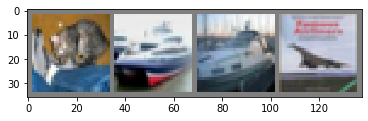

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [21]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Chooses a test image at index `ind` for interpretation purposes

In [22]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

In [23]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
)

In [24]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    print(kwargs.get('baselines').shape)
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions
        

Computes gradients and transposes them for visualization purposes

In [25]:
saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

Applies integrated gradients on test image

In [26]:
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', delta)

torch.Size([1, 3, 32, 32])
Approximation delta:  0.024312853813171387


Applies integrated gradients with smoothgrad square on test image

In [27]:
ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt, delta = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                             n_samples=100, noise_frac=0.2)

attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))


torch.Size([1, 3, 32, 32])


Applies DeepLift on test image

In [28]:
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

torch.Size([1, 3, 32, 32])


In [29]:
img_gradient_overlay = viz.visualize_image(grads,
                                     np.transpose(images[ind].cpu().detach().numpy(), (1, 2, 0)),
                                     clip_above_percentile=85, clip_below_percentile=0,
                                     overlay=True,
                                     mask_mode=True)

img_integrated_gradient_overlay = viz.visualize_image(attr_ig,
                                      np.transpose(images[ind].cpu().detach().numpy(), (1, 2, 0)),
                                      clip_above_percentile=99,
                                      clip_below_percentile=0,
                                      overlay=True,
                                      mask_mode=True)
img_integrated_gradient_nt_overlay = viz.visualize_image(attr_ig_nt,
                                      np.transpose(images[ind].cpu().detach().numpy(), (1, 2, 0)),
                                      clip_above_percentile=99,
                                      clip_below_percentile=0,
                                      overlay=True,
                                      mask_mode=True)

img_deeplift_overlay = viz.visualize_image(attr_dl,
                                     np.transpose(images[ind].cpu().detach().numpy(), (1, 2, 0)),
                                     clip_above_percentile=99, clip_below_percentile=0,
                                     overlay=True,
                                     mask_mode=True)


Original Image
Predicted: ship  Probability: 0.668495774269104


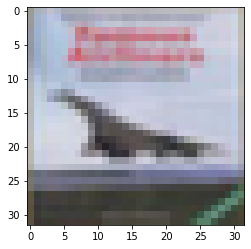

Gradients with overlay


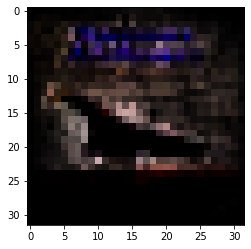

Integrated Gradients with overlay


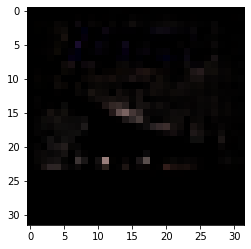

Integrated Gradients with smoothgrad square and overlay


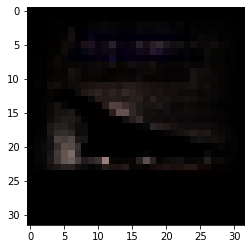

DeepLift with overlay


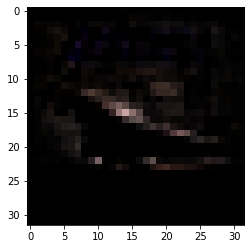

In [30]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

imshow(images[ind])

print('Gradients with overlay')
plt.imshow(img_gradient_overlay)
plt.show()

print('Integrated Gradients with overlay')
plt.imshow(img_integrated_gradient_overlay)
plt.show()

print('Integrated Gradients with smoothgrad square and overlay')
plt.imshow(img_integrated_gradient_nt_overlay)
plt.show()

print('DeepLift with overlay')
plt.imshow(img_deeplift_overlay)
plt.show()